[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ktehranchi/energy310_notebooks/blob/main/notebooks/03_capacity_expansion_in_PyPSA.ipynb)


In [84]:
# Install required packages if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Installing required packages for Google Colab...")
    %pip install -q pypsa matplotlib numpy pandas seaborn scipy networkx gurobipy
    print("Setup complete!")
else:
    print("Not running in Colab. Skipping package installation.")


Installing required packages for Google Colab...
Setup complete!


# Capacity Expansion in PyPSA

This notebook is developed by [Dr. Fabian Neumann](https://fneum.org) and is used for the curriculum of the [Department of Digital Transformation of Energy Systems at TU Berlin](https://www.tu.berlin/ensys).

$$
\begin{aligned}
\min_{p, s, \bar{p}, \bar{s}, \bar{f}, f}
&\sum_{a \in A} \omega_a \Bigg[
\sum_{t \in T^a} \omega_{a,t} \Bigg(
\sum_{g \in G} o_{g,a,t} \cdot p_{g,a,t}
\Bigg)
+ \sum_{g \in G} c_{g,a} \cdot \bar{p}_{g}
+ \sum_{s \in S} c_s \cdot \bar{s}_{s}
+ \sum_{b \in B} c_b \cdot \bar{f}_{b}
\Bigg] \\[0.5em]
\quad
\newline
\newline
\text{subject to:} \quad
&\widetilde{p}_{g,a,t}^{\text{min}} \bar{p}_{g}
  \leq p_{g,a,t}
  \leq \widetilde{p}_{g,a,t}^{\text{max}} \bar{p}_{g}
  && \forall g \in G,\; a \in A,\; t \in T_a \\[0.5em]
& RD_g \leq p_{g,a,t} - p_{g,a,{t-1}} \leq RU_g
  && \forall g \in G,\; a \in A,\; t \in T_a   \\[0.5em]
& \sum_{g \in G_z} \bar{p}_{g} \leq \bar{p}^{\text{max}}_{g,z}
  && \forall z \in Z     \\[0.5em]
& 0 \leq SOC_{s,a,t} \leq h_s \bar{s}_{s}
  && \forall s \in S,\; a \in A,\; t \in T_a    \\[0.5em]
& 0 \leq s_{s,a,t}^{out} \leq \bar{s}_{s}
  && \forall s \in S,\; a \in A,\; t \in T_a     \\[0.5em]
& 0 \leq s_{s,a,t}^{in} \leq \bar{s}_{s}
  && \forall s \in S,\; a \in A,\; t \in T_a      \\[0.5em]
& SOC_{s,a,t} = SOC_{s,a,t-1}
  + \eta^{in} s_{s,a,t}^{in}
  - \frac{1}{\eta^{out}} s_{s,a,t}^{out}
  && \forall s \in S,\; a \in A,\; t \in T_a      \\[0.5em]
& \widetilde{f}_{b,a,t}^{\text{min}} \bar{f}_{b}
  \leq f_{b,a,t}
  \leq \widetilde{f}_{b,a,t}^{\text{max}} \bar{f}_{b}
  && \forall b \in B,\; a \in A,\; t \in T_a     \\[0.5em]
& \sum_g p_{g,a,t,n}
+ \sum_s s_{s,a,t,n}^{out}
- \sum_s s_{s,a,t,n}^{in}
- \sum_b K_{b,n} f_{b,a,t}  = D_{a,t,n}  \forall n \in N,\; a \in A,\; t \in T_a
\end{aligned}
$$

In [85]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt

## Loading technology data and costs

PyPSA developers maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [86]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [87]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [88]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [89]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the short-term marginal generation costs (STMGC, €/MWh):

In [90]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [91]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [92]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

## Loading time series data

We are also going to need some time series for wind, solar and load. For now, we are going to recycle the time series we used at the beginning of the course. They are given for Germany in the year 2015.

In [93]:
url = (
    "https://tubcloud.tu-berlin.de/s/pKttFadrbTKSJKF/download/time-series-lecture-2.csv"
)
ts = pd.read_csv(url, index_col=0, parse_dates=True)

In [94]:
ts.head(3)

,load,onwind,offwind,solar,prices
2015-01-01 00:00:00,41.151,0.1566,0.7030,0.0,NaN
2015-01-01 01:00:00,40.135,0.1659,0.6875,0.0,NaN
2015-01-01 02:00:00,39.106,0.1746,0.6535,0.0,NaN


Let's convert the load time series from GW to MW, the base unit of PyPSA:

In [95]:
ts.load *= 1e3

We are also going to adapt the temporal resolution of the time series, e.g. sample only every other hour, to save some time:

In [96]:
resolution = 4
ts = ts.resample(f"{resolution}h").first()

## Simple capacity expansion planning example

:::{note}
See also https://model.energy.
:::

**In this tutorial, we want to build a replica of [model.energy](https://model.energy).** This tool calculates the cost of meeting a constant electricity demand from a combination of wind power, solar power and storage for different regions of the world.

We deviate from [model.energy](https://model.energy) by including offshore wind generation and electricity demand profiles rather than a constant electricity demand. Also, we are going to start with Germany only. You can adapt the code to other countries as an exercise.

### Model Initialisation

For building the model, we start again by initialising an empty network.

In [97]:
n = pypsa.Network()

Then, we add a single bus...

In [98]:
n.add("Bus", "electricity")

...and tell the `pypsa.Network` object `n` what the snapshots of the model will be using the utility function `n.set_snapshots()`.

In [99]:
n.set_snapshots(ts.index)

In [100]:
n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 04:00:00',
               '2015-01-01 08:00:00', '2015-01-01 12:00:00',
               '2015-01-01 16:00:00', '2015-01-01 20:00:00',
               '2015-01-02 00:00:00', '2015-01-02 04:00:00',
               '2015-01-02 08:00:00', '2015-01-02 12:00:00',
               ...
               '2015-12-30 08:00:00', '2015-12-30 12:00:00',
               '2015-12-30 16:00:00', '2015-12-30 20:00:00',
               '2015-12-31 00:00:00', '2015-12-31 04:00:00',
               '2015-12-31 08:00:00', '2015-12-31 12:00:00',
               '2015-12-31 16:00:00', '2015-12-31 20:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2190, freq='4h')

The weighting of the snapshots (e.g. how many hours they represent, see $w_t$ in problem formulation above) can be set in `n.snapshot_weightings`.

In [101]:
n.snapshot_weightings.head(3)

,objective,stores,generators
snapshot,,,
2015-01-01 00:00:00,1.0,1.0,1.0
2015-01-01 04:00:00,1.0,1.0,1.0
2015-01-01 08:00:00,1.0,1.0,1.0


In [102]:
n.snapshot_weightings.loc[:, :] = resolution

In [103]:
n.snapshot_weightings.head(3)

,objective,stores,generators
snapshot,,,
2015-01-01 00:00:00,4.0,4.0,4.0
2015-01-01 04:00:00,4.0,4.0,4.0
2015-01-01 08:00:00,4.0,4.0,4.0


### Adding Components

Then, we add all the technologies we are going to include as carriers.

In [104]:
carriers = [
    "onwind",
    "offwind",
    "solar",
    "OCGT",
    "CCGT",
    "hydrogen storage underground",
    "battery storage",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "aquamarine", "gold", "indianred", "orange", "magenta", "yellowgreen"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Next, we add the demand time series to the model.

In [105]:
n.add(
    "Load",
    "demand",
    bus="electricity",
    p_set=ts.load,
)

Let's have a check whether the data was read-in correctly.

<Axes: xlabel='snapshot', ylabel='MW'>

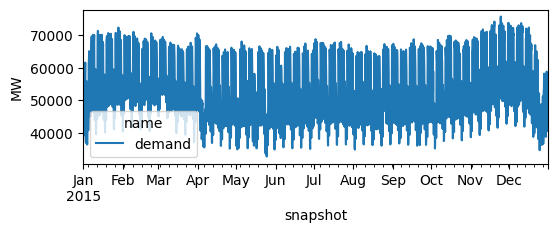

In [106]:
n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We are going to add one dispatchable generation technology to the model. This is an open-cycle gas turbine (OCGT) with CO$_2$ emissions of 0.2 t/MWh$_{th}$.

In [107]:
n.add(
    "Generator",
    "OCGT",
    bus="electricity",
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)
n.add(
    "Generator",
    "CCGT",
    bus="electricity",
    carrier="CCGT",
    capital_cost=costs.at["CCGT", "capital_cost"],
    marginal_cost=costs.at["CCGT", "marginal_cost"],
    efficiency=costs.at["CCGT", "efficiency"],
    p_nom_extendable=True,
)

Adding the variable renewable generators works almost identically, but we also need to supply the capacity factors to the model via the attribute `p_max_pu`.

In [108]:
for tech in ["onwind", "offwind", "solar"]:
    n.add(
        "Generator",
        tech,
        bus="electricity",
        carrier=tech,
        p_max_pu=ts[tech],
        capital_cost=costs.at[tech, "capital_cost"],
        marginal_cost=costs.at[tech, "marginal_cost"],
        efficiency=costs.at[tech, "efficiency"],
        p_nom_extendable=True,
    )

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

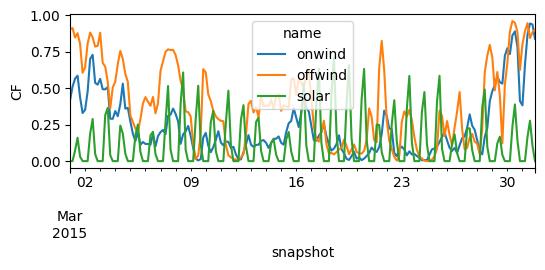

In [109]:
n.generators_t.p_max_pu.loc["2015-03"].plot(figsize=(6, 2), ylabel="CF")

### Model Run

Then, we can already solve the model for the first time. At this stage, the model does not have any storage or emission limits implemented. It's going to look for the least-cost combination of variable renewables and the gas turbine to supply demand.

In [110]:
n.optimize(solver_name="highs")

Index(['electricity'], dtype='object', name='name')
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.53it/s]


('ok', 'optimal')

### Model Evaluation

The total system cost in billion Euros per year:

In [111]:
n.objective / 1e9

29.252333850553406

The optimised capacities in GW:

In [112]:
n.generators.p_nom_opt.div(1e3)  # GW

,p_nom_opt
name,
OCGT,23.404960
CCGT,49.094362
onwind,-0.000000
offwind,5.762926
solar,73.671552


The total energy generation by technology in GW:

In [113]:
n.snapshot_weightings.generators @ n.generators_t.p.div(1e6)  # TWh

,generators
name,
OCGT,21.569786
CCGT,359.073695
onwind,0.000000
offwind,18.287196
solar,79.995063


While we get the objective value through `n.objective`, in many cases we want to know how the costs are distributed across the technologies. We can use the statistics module for this:

In [114]:
(n.statistics.capex() + n.statistics.opex()).div(1e6)

component  carrier
Generator  CCGT       21950.270494
           OCGT        2512.072557
           offwind     1006.342215
           solar       3783.648585
dtype: float64

Possibly, we are also interested in the total emissions:

In [115]:
emissions = (
    n.generators_t.p
    / n.generators.efficiency
    * n.generators.carrier.map(n.carriers.co2_emissions)
)  # t/h

In [116]:
n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6)  # Mt

np.float64(132.99695876575817)

### Plotting Optimal Dispatch

This function takes the network object `n` as an argument and, optionally, a time frame. We want to plot the load time series, and stacked area charts for electricity feed-in and storage charging. Technologies should be coloured by their color defined in `n.carriers`.

In [117]:
def plot_dispatch(n, time="2015-07"):
    p = (
        n.statistics.energy_balance(aggregate_time=False)
        .groupby("carrier")
        .sum()
        .div(1e3)
        .drop("-")
        .T
    )

    fig, ax = plt.subplots(figsize=(6, 3))

    color = p.columns.map(n.carriers.color)

    p.where(p > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )

    charge = p.where(p < 0).dropna(how="all", axis=1).loc[time]

    if not charge.empty:
        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )

    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k")

    plt.legend(loc=(1.05, 0))
    ax.set_ylabel("GW")
    ax.set_ylim(-100, 200)

Let's test it:

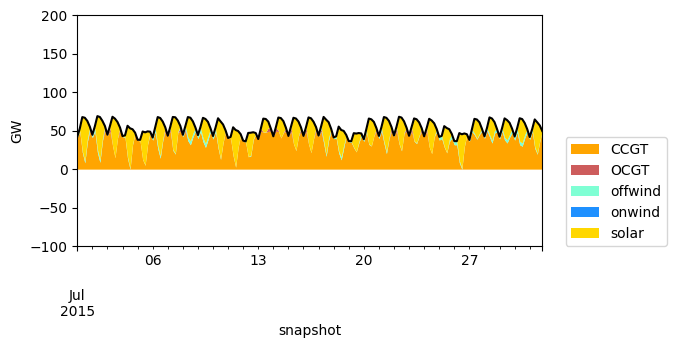

In [118]:
plot_dispatch(n)

## Adding Storage Units

Alright, but there are a few important components missing for a system with high shares of renewables? What about short-term storage options (e.g. batteries) and long-term storage options (e.g. hydrogen storage)? Let's add them too.

First, the battery storage. We are going to assume a fixed energy-to-power ratio of 6 hours, i.e. if fully charged, the battery can discharge at full capacity for 6 hours.
For the capital cost, we have to factor in both the capacity and energy cost of the storage. We are also going to enforce a cyclic state-of-charge condition, i.e. the state of charge
at the beginning of the optimisation period must equal the final state of charge.

In [119]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=6,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 6 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Second, the hydrogen storage. This one is composed of an electrolysis to convert electricity to hydrogen, a fuel cell to re-convert hydrogen to electricity and underground storage (e.g. in salt caverns). We assume an energy-to-power ratio of 168 hours, such that this type of storage can be used for weekly balancing.

In [120]:
capital_costs = (
    costs.at["electrolysis", "capital_cost"]
    + costs.at["fuel cell", "capital_cost"]
    + 168 * costs.at["hydrogen storage underground", "capital_cost"]
)

n.add(
    "StorageUnit",
    "hydrogen storage underground",
    bus="electricity",
    carrier="hydrogen storage underground",
    max_hours=168,
    capital_cost=capital_costs,
    efficiency_store=costs.at["electrolysis", "efficiency"],
    efficiency_dispatch=costs.at["fuel cell", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Ok, lets run the again, now with storage, and see what's changed.

In [121]:
n.optimize(solver_name="highs")

Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 20.51it/s]


('ok', 'optimal')

In [122]:
n.generators.p_nom_opt  # MW

,p_nom_opt
name,
OCGT,23404.959647
CCGT,49094.361917
onwind,-0.000000
offwind,5762.925599
solar,73671.551890


In [123]:
n.storage_units.p_nom_opt  # MW

,p_nom_opt
name,
battery storage,-0.0
hydrogen storage underground,-0.0


**Nothing!** The objective value is the same, and no storage is built.

### Adding emission limits

The gas power plant offers sufficient and cheap enough backup capacity to run in periods of low wind and solar generation. But what happens if this source of flexibility disappears. Let's model a 100% renewable electricity system by adding a CO$_2$ emission limit as global constraint:

In [124]:
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=0,
)

When we run the model now...

In [125]:
n.optimize(solver_name="highs")

Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 38.71it/s]


('ok', 'optimal')

...and inspect the capacities built...

In [126]:
n.generators.p_nom_opt  # MW

,p_nom_opt
name,
OCGT,-0.000000
CCGT,-0.000000
onwind,267431.119057
offwind,61878.836900
solar,288960.778468


In [127]:
n.storage_units.p_nom_opt  # MW

,p_nom_opt
name,
battery storage,50461.162073
hydrogen storage underground,48721.593436


In [128]:
n.storage_units.p_nom_opt.div(1e3) * n.storage_units.max_hours  # GWh

,0
name,
battery storage,302.766972
hydrogen storage underground,8185.227697


... we now see some storage. So how does the optimised dispatch of the system look like?

/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1794: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



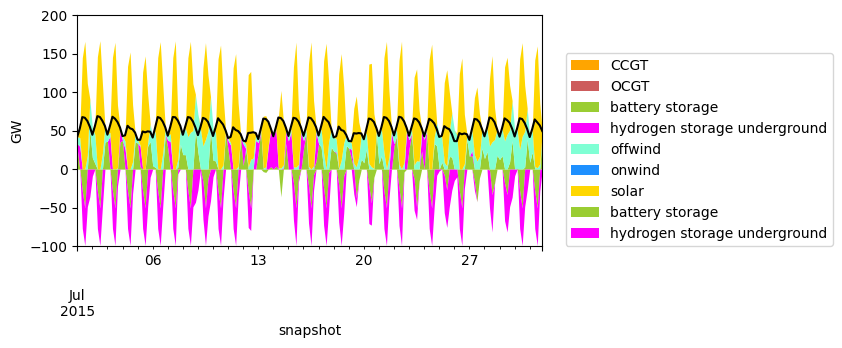

In [129]:
plot_dispatch(n)

We are also keen to see what technologies constitute the largest cost components. For that we're going to define a small helper function:

In [130]:
def system_cost(n):
    tsc = pd.concat([n.statistics.capex(), n.statistics.opex()], axis=1)
    return tsc.sum(axis=1).droplevel(0).div(1e9).round(2)  # billion €/a

In [131]:
system_cost(n)

,0
carrier,
offwind,10.81
onwind,27.29
solar,14.84
battery storage,5.17
hydrogen storage underground,21.33


This series, we can then process into plots, e.g. a pie chart:

<Axes: >

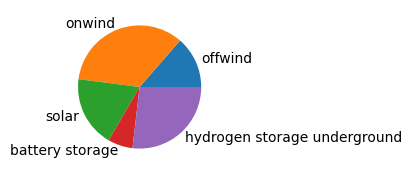

In [132]:
system_cost(n).plot.pie(figsize=(2, 2))

or use to compute the cost per unit of electricity consumed:

In [133]:
demand = n.snapshot_weightings.generators @ n.loads_t.p_set.sum(axis=1)

In [134]:
system_cost(n).sum() * 1e9 / demand.sum()

np.float64(165.87122671669306)

In [135]:
n.export_to_netcdf("network-new.nc");

:::{warning}
Always consider, that the load data is given in units of power (MW) and if your resolution is not hourly, you need to multiply by the snapshot weighting to get the energy consumed!
:::

## Sensitivity Analysis

Sensitivity analyses constitute a core activity of energy system modelling. Below, you can find sensitivity analyses regarding the

1. variation in allowed CO$_2$ emissions
2. variation in solar overnight costs
3. variation in offshore wind potentials

In [ ]:
sensitivity = {}
for co2 in [150, 100, 50, 25, 0]:
    n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    n.optimize(solver_name="highs")
    sensitivity[co2] = system_cost(n)

Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 90.43it/s]
Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 80.07it/s]
Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 87.66it/s]
Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 54.23it/s]
Index(['electricity'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')


In [ ]:
df = pd.DataFrame(sensitivity).T  # billion Euro/a
df.plot.area(
    stacked=True,
    linewidth=0,
    color=df.columns.map(n.carriers.color),
    figsize=(4, 4),
    xlim=(0, 150),
    xlabel=r"CO$_2$ emissions [Mt/a]",
    ylabel="System cost [bn€/a]",
    ylim=(0, 100),
)
plt.legend(frameon=False, loc=(1.05, 0))

## Exercises

Explore the model by changing the assumptions and available technologies. Here are a few inspirations:

- Rerun the model with cost assumptions for 2050.
- What if either hydrogen or battery storage cannot be expanded?
- What if you can either only build solar or only build wind?
- What if we had a flat electricity demand profile (like in [model.energy](https://model.energy), i.e. average the demand time series)?
- Vary the energy-to-power ratio of the hydrogen storage. What ratio leads to lowest costs?
- How bad is the 4-hourly resolution used for demonstration? How does it compare to hourly or 2-hourly resolution?
- On [model.energy](https://model.energy), you can download capacity factors for onshore wind and solar for any region in the world. Drop offshore wind from the model and use the onshore wind and solar prices from another region of the world. Try a few. What changes?
- Add nuclear as another dispatchable low-emission generation technology (similar to OCGT). Perform a sensitivity analysis trying to answer how low the capital cost of a nuclear plant would need to be to be chosen.